###1. Importing Libraries

In [2]:
!pip install lazypredict -q
!pip install scikit-optimize -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.4/703.4 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoLars
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer,mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.decomposition import PCA
import shap

###2. Data Loading & Preprocessing

In [4]:
np.set_printoptions(suppress=True, precision=2)

In [5]:
df = pd.read_csv("/content/df_performance.csv",index_col=0)

In [6]:
cols_obj = ['performance_model20T-1',
       'performance_model20T-2', 'performance_model30T-1',
       'performance_model30T-2', 'performance_model30T-3',
       'performance_model36T-1', 'performance_model36T-2',
       'performance_model39T-1', 'performance_model39T-2',
       'performance_model49T-1']


y = df[cols_obj ]


X = df.drop(columns=cols_obj )

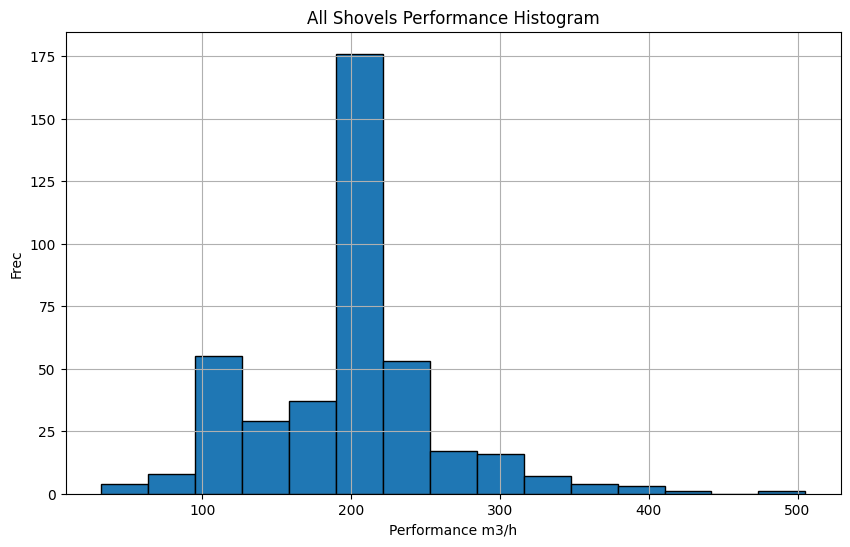

197.59


In [7]:
plt.figure(figsize=(10, 6))
plt.hist(y.values.flatten()[y.values.flatten()>0], bins=15, edgecolor='black')
plt.title('All Shovels Performance Histogram')
plt.xlabel('Performance m3/h')
plt.ylabel('Frec')
plt.grid(True)
plt.show()
print(y.values.flatten()[y.values.flatten()>0].mean().round(2))

In [8]:
filter = df.columns[~df.columns.isin(cols_obj)]
hist = pd.melt(df, id_vars=filter, value_vars=cols_obj, var_name='shovel', value_name='performance')[["shovel","performance"]]
hist["shovel"] = hist["shovel"].str.replace(r'performance_|-1|-2|-3|-6|-10|-4|-9|-13|-14|-8',"", regex=True)
hist = hist[hist["performance"]>0]
hist = hist[~hist['shovel'].str.contains('model20T')]

     shovel  performance
0  model30T   209.038710
1  model36T   214.134694
2  model39T   196.159859
3  model49T   241.531746


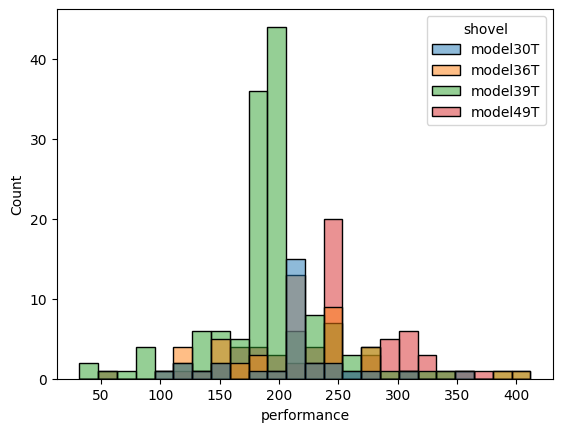

In [9]:
import seaborn as sns

# Equivalent to:
sns.histplot(x = "performance", hue = "shovel", data = hist)
promedio_por_maquina = hist.groupby('shovel')['performance'].mean().reset_index()
print(promedio_por_maquina)

###3. Defining metrics for result evaluation

In [10]:
def rmsepositive(y_true, y_pred):
    ypositive = np.clip(y_pred,4,250)
    return np.sqrt(mean_squared_error(y_true, ypositive))

rmse_positive = make_scorer(rmsepositive, greater_is_better=False)

def r2positive(y_true, y_pred):
    ypositive = np.clip(y_pred,4,250)
    return r2_score(y_true, ypositive)

r2_positive = make_scorer(r2positive, greater_is_better=True)

In [11]:
# A mechanism was established to properly assess values close to 0,
# since some regression models are not robust when handling such values,
# whereas in reality a machine may indeed present a value of 0 when idle
# or out of operation.


def plot_rmse_vs_x(a, b, max_x=300):
    rmse_values = []
    x_values = range(0, max_x + 1)

    for x in x_values:
        b_copy = b.copy()
        b_copy[b_copy < x] = 0
        rmse = root_mean_squared_error(a, b_copy)
        rmse_values.append(rmse)

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, rmse_values, label='RMSE')
    plt.xlabel('x')
    plt.ylabel('RMSE')
    plt.title('RMSE vs x')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rmse_values

In [12]:
def graf_shap(model, ml_model, X_test, y_test):
  # Extract the scaler and the model from the pipeline
  # Check if the pipeline contains a scaler or log transformer
  if 'scaler' in best_model.named_steps:
      transformer = best_model.named_steps['scaler']
  elif 'log' in best_model.named_steps:
      transformer = best_model.named_steps['log']
  else:
      raise ValueError("Pipeline must contain either a 'scaler' or 'log' step.")

  ml = best_model.named_steps[ml_model]

  # Scale the training and testing data manually
  X_train_scaled = transformer.transform(X_train)
  X_test_scaled = transformer.transform(X_test)

  # Use KernelExplainer with the extracted model and scaled data
  explainer = shap.KernelExplainer(ml.predict, X_train_scaled)
  shap_values = explainer(X_test_scaled)

  class_labels = y.columns

  plt.figure(figsize=(40, 30))
  shap.summary_plot(shap_values, X_test_scaled, class_names=class_labels, feature_names=X_test.columns, show=False)
  plt.legend(loc="lower right", bbox_to_anchor=(1, -0.1))
  plt.show()

  return plt.show()

def graf_tree_shap(best_model, ml_model, X_test, y_test):

  # Extract the scaler and the model from the pipeline
  # Check if the pipeline contains a scaler or log transformer
  if 'scaler' in best_model.named_steps:
      transformer = best_model.named_steps['scaler']
  elif 'log' in best_model.named_steps:
      transformer = best_model.named_steps['log']
  else:
      raise ValueError("Pipeline must contain either a 'scaler' or 'log' step.")

  ml = best_model.named_steps[ml_model]

  # Scale the training and testing data manually
  # Assuming X_train is available in the global scope
  X_train_scaled = transformer.transform(X_train)
  X_test_scaled = transformer.transform(X_test)

  # Use KernelExplainer with the extracted model and scaled data
  explainer = shap.TreeExplainer(ml)
  shap_values = explainer.shap_values(X_test_scaled)

  class_labels = y.columns

  plt.figure(figsize=(40, 30))
  shap.summary_plot(shap_values, X_test_scaled, class_names=class_labels, feature_names=X_test.columns,plot_type="bar",show=False)
  plt.legend(loc="lower right", bbox_to_anchor=(1, -0.1))
  plt.show()

  return plt.show()

In [13]:
corr_matrix = df.corr()
print("Correlation Matrix:")
corr_matrix[cols_obj]

Correlation Matrix:


,performance_model20T-1,performance_model20T-2,performance_model30T-1,performance_model30T-2,performance_model30T-3,performance_model36T-1,performance_model36T-2,performance_model39T-1,performance_model39T-2,performance_model49T-1
gal_hour_model20T-1,0.199617,0.004960,-0.194543,-0.157142,-0.191000,-0.088838,-0.199655,-0.028232,0.113228,-0.063859
gal_hour_model20T-2,-0.001554,0.815157,-0.156542,-0.150842,-0.204472,-0.040623,0.056044,0.122358,0.151768,-0.028874
gal_hour_model30T-1,0.009011,-0.205378,0.966240,0.937552,0.214238,-0.145792,0.159068,0.023687,0.050706,-0.290430
gal_hour_model30T-2,0.009010,-0.205367,0.965181,0.938963,0.214226,-0.145785,0.158154,0.023686,0.050704,-0.290414
gal_hour_model30T-3,-0.011410,-0.278740,0.176615,0.181092,0.961313,0.498572,0.460259,-0.227246,-0.240405,-0.104342
...,...,...,...,...,...,...,...,...,...,...
truck_trips_15.0m3,0.044548,-0.093904,0.376638,0.368919,-0.281343,-0.576746,-0.199884,0.243878,0.104826,0.150216
truck_trips_24.0m3,-0.175725,-0.083433,0.129053,0.129613,0.387265,0.331687,0.234647,-0.271409,-0.274544,0.009425
truck_trips_25.0m3,-0.005213,-0.252812,0.181414,0.166653,-0.251014,-0.452711,-0.065966,0.104789,0.356541,-0.056804
truck_trips_27.0m3,0.113597,-0.069196,0.106485,0.090634,-0.612054,-0.765544,-0.353866,0.170161,0.213828,0.130875


In [ ]:
# @title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }

performance_shovel = "performance_model36T-2" # @param ['performance_model20T-1','performance_model20T-2','performance_model30T-1','performance_model30T-2','performance_model30T-3','performance_model36T-1','performance_model36T-2','performance_model39T-1','performance_model39T-2','performance_model49T-1']
print('You selected', performance_shovel)

corr_matrix = df.corr()
print("Correlation Matrix:")
corr_matrix[performance_shovel ].sort_values(ascending=False)

### 4. Model Training & Hyperparameter Tuning

In [15]:
scoring = {
    "R2": "r2",
    "RMSE": "neg_root_mean_squared_error"
}

def adjusted_r2_score(y_true, y_pred, p):
    r2 = r2_score(y_true, y_pred)
    Adj_r2 = 1-(1-r2)*(len(y_true)-1)/(len(y_true)-p-1)
    return Adj_r2

In [16]:
# @title
from lazypredict.Supervised import LazyRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=.2, random_state =42)

reg = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)

models1,predictions = reg.fit(X_train, X_test, y_train, y_test)


  0%|          | 0/42 [00:00<?, ?it/s]

In [17]:
predictions.sort_values(by="R-Squared", ascending=False)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,1.13,0.60,46.64,0.37
RandomForestRegressor,1.14,0.57,48.78,0.67
KNeighborsRegressor,1.15,0.56,48.32,0.07
BaggingRegressor,1.16,0.52,49.73,0.18
Lasso,1.16,0.51,47.95,0.05
XGBRegressor,1.19,0.41,52.41,4.65
ElasticNet,1.24,0.28,47.88,0.04
RidgeCV,1.26,0.20,50.38,0.16
ExtraTreeRegressor,1.27,0.16,66.86,0.02


### 4.1 KNeighborsRegressor()

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

class LogTransformer(BaseEstimator, TransformerMixin):
    """Aplica log(1+x) a las características para manejar ceros."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.log1p(1+X)  # log(1+x)

In [19]:
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('knn', KNeighborsRegressor())
# ])

pipeline = Pipeline([
    ("log", LogTransformer()),
    ('knn', KNeighborsRegressor())
])

param_grid = {
    'knn__n_neighbors': range(1, 31),
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(10), scoring=scoring, n_jobs=-1, refit="R2")
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print()

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Root Mean Squared Error con el mejor modelo: {rmse:.2f}')
print(f'R2 con el mejor modelo: {r2:.2f}')
print()

best_rmse_scores = cross_val_score(best_model, X, y, cv=KFold(10), scoring="neg_root_mean_squared_error")

print("RMSE:", best_rmse_scores.round(2))
print(f'Media rmse score: {np.mean(best_rmse_scores):.2f}')

Mejores hiperparámetros: {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Root Mean Squared Error con el mejor modelo: 44.94
R2 con el mejor modelo: 0.54

RMSE: [-29.76 -38.03 -30.07 -22.34 -28.47 -39.4  -42.84 -43.88 -61.79 -67.8 ]
Media rmse score: -40.44


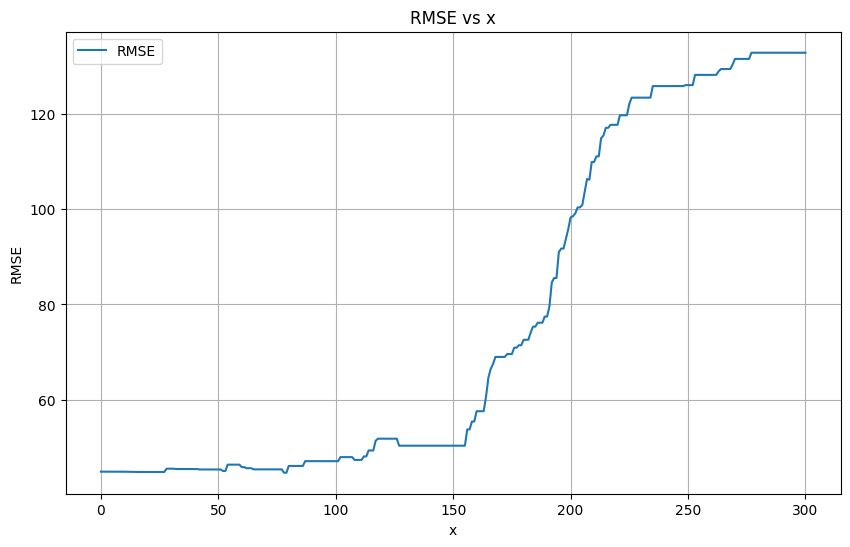

In [20]:
rmse_values = plot_rmse_vs_x(y_test, y_pred)

In [21]:
indices = np.where(rmse_values == np.min(rmse_values))

if indices[0].size > 0:
    print(f'The value {np.min(rmse_values)} is located at position {indices[0][0]}')
else:
    print(f'The value {np.min(rmse_values)} is not found in the array')

The value 44.715467172180944 is located at position 78


In [22]:
y_model = y_pred.copy()
y_model[y_pred < indices[0][0]] = 0
rmse = root_mean_squared_error(y_test, y_model)
r2 = r2_score(y_test, y_model)
r2_adj = adjusted_r2_score(y_test, y_model, X.shape[1])
print(f'Root Mean Squared Error with the best model: {rmse:.2f}')
print(f'R2: {r2:.3f}')
print(f'Adjusted R2: {r2_adj:.3f}')

Root Mean Squared Error with the best model: 44.72
R2: 0.472
Adjusted R2: 1.172


  0%|          | 0/16 [00:00<?, ?it/s]

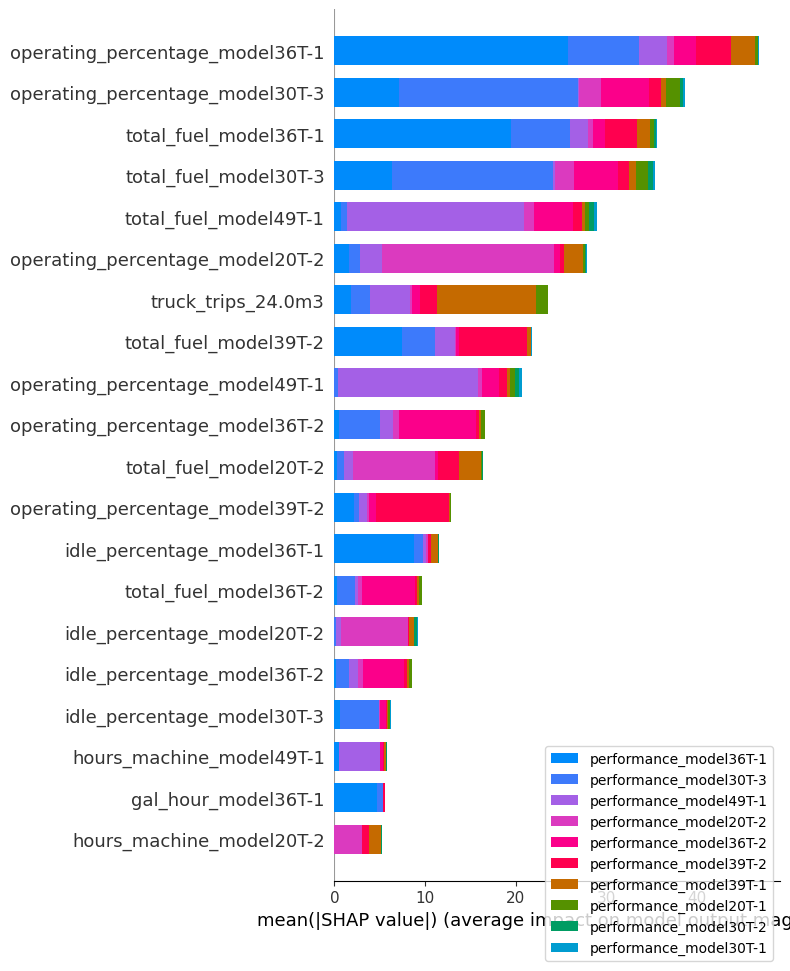

In [23]:
graf_shap(best_model, "knn", X_test, y_test)

### 4.2 ExtraTreeRegressor()

In [24]:
pipeline_et = Pipeline([
    ("log", LogTransformer()),
    ('et', ExtraTreesRegressor(random_state=42))
])

# pipeline_et = Pipeline([
#     ('scaler', StandardScaler()),
#     ('et', ExtraTreesRegressor(random_state=42))
# ])

param_grid_et = {
    'et__n_estimators': [50,100,150],
    'et__max_depth': [None, 5, 7],
    'et__min_samples_split': [12, 5, 10],
    'et__min_samples_leaf': [1, 2, 4],
    'et__max_features': ['sqrt', 'log2']
}

grid_search_et = GridSearchCV(pipeline_et, param_grid_et, cv=KFold(10), scoring={'R2':'r2','RMSE':'neg_root_mean_squared_error'}, n_jobs=-1, refit="R2")
grid_search_et.fit(X_train, y_train)

print("Best hyperparameters ExtraTrees:", grid_search_et.best_params_)
best_model_et = grid_search_et.best_estimator_
y_pred_et = best_model_et.predict(X_test)
rmse_et = root_mean_squared_error(y_test, y_pred_et)
r2_et = r2_score(y_test, y_pred_et)
print(f'ExtraTrees RMSE: {rmse_et:.2f}')
print(f'ExtraTrees R2: {r2_et:.2f}')
print()

scores_et = cross_val_score(best_model_et, X, y, cv=KFold(10), scoring="neg_root_mean_squared_error")
print("Cross-val RMSE:", scores_et.round(2))
print(f'Mean RMSE score: {np.mean(scores_et):.2f}')

Best hyperparameters ExtraTrees: {'et__max_depth': 7, 'et__max_features': 'log2', 'et__min_samples_leaf': 1, 'et__min_samples_split': 5, 'et__n_estimators': 100}
ExtraTrees RMSE: 42.78
ExtraTrees R2: 0.60

Cross-val RMSE: [-31.95 -42.68 -31.12 -23.66 -33.22 -36.05 -46.5  -46.32 -58.13 -68.3 ]
Mean RMSE score: -41.79


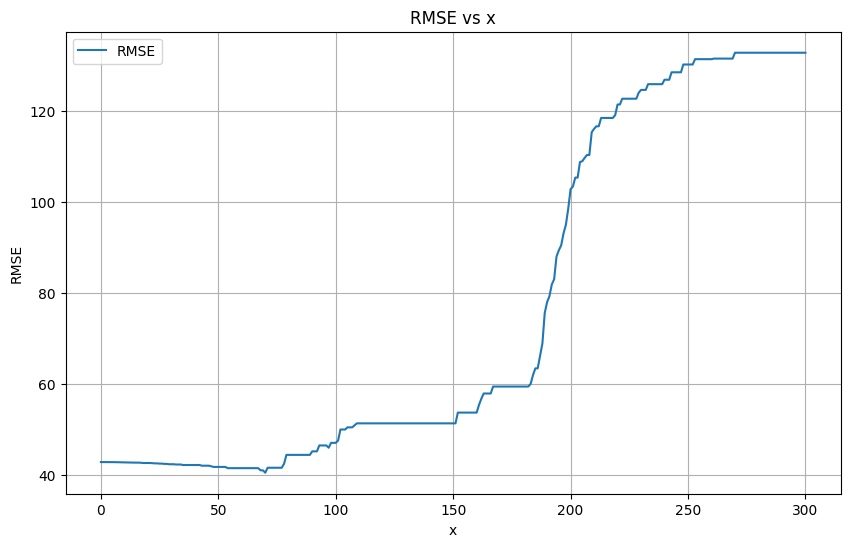

In [25]:
rmse_values = plot_rmse_vs_x(y_test, y_pred_et)

In [26]:
indices = np.where(rmse_values == np.min(rmse_values))

if indices[0].size > 0:
    print(f'The value {np.min(rmse_values)} is located at position {indices[0][0]}')
else:
    print(f'The value {np.min(rmse_values)} is not found in the array')

The value 40.43325475959724 is located at position 70


In [27]:
y_model = y_pred_et.copy()
y_model[y_pred_et < indices[0][0]] = 0
rmse = root_mean_squared_error(y_test, y_model)
r2 = r2_score(y_test, y_model)
r2_adj = adjusted_r2_score(y_test, y_model, X.shape[1])
print(f'Root Mean Squared Error with the best model: {rmse:.2f}')
print(f'R2: {r2:.3f}')
print(f'Adjusted R2: {r2_adj:.3f}')

Root Mean Squared Error with the best model: 40.43
R2: 0.631
Adjusted R2: 1.120


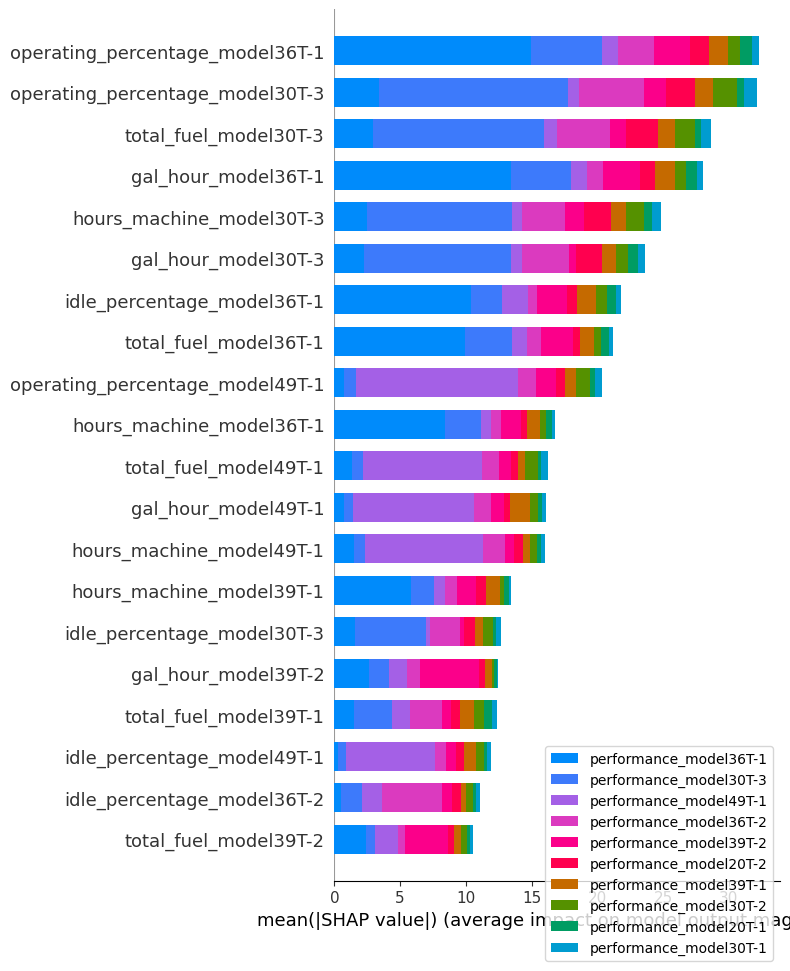

In [28]:
graf_tree_shap(best_model_et, "et", X_test, y_test)

### 4.3 RandonForestRegressor()

In [29]:
# pipeline_rf = Pipeline([
#     ('scaler', StandardScaler()),
#     ('rf', RandomForestRegressor(random_state=42))
# ])

pipeline_rf = Pipeline([
    ("log", LogTransformer()),
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=KFold(10), scoring={'R2':'r2','RMSE':'neg_root_mean_squared_error'}, n_jobs=-1, refit="R2")
grid_search_rf.fit(X_train, y_train)

print("Best hyperparameters RandomForest:", grid_search_rf.best_params_)
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'RandomForest RMSE: {rmse_rf:.2f}')
print(f'RandomForest R2: {r2_rf:.2f}')
print()

scores_rf = cross_val_score(best_model_rf, X, y, cv=KFold(10), scoring="neg_root_mean_squared_error")
print("Cross-val RMSE:", scores_rf.round(2))
print(f'Mean RMSE score: {np.mean(scores_rf):.2f}')

Best hyperparameters RandomForest: {'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
RandomForest RMSE: 44.53
RandomForest R2: 0.57

Cross-val RMSE: [-31.28 -42.45 -32.17 -25.83 -32.94 -39.71 -47.09 -46.42 -60.53 -72.69]
Mean RMSE score: -43.11


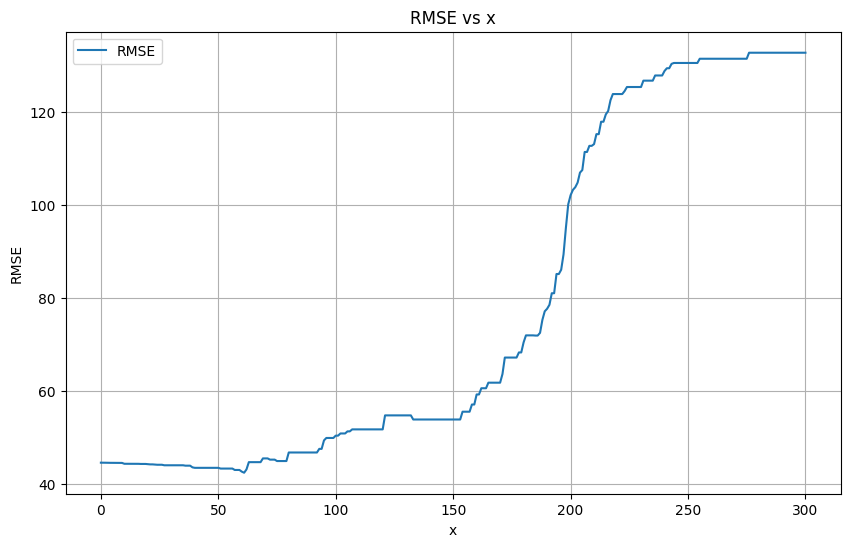

In [30]:
rmse_values = plot_rmse_vs_x(y_test, y_pred_rf)

In [31]:
indices = np.where(rmse_values == np.min(rmse_values))

if indices[0].size > 0:
    print(f'The value {np.min(rmse_values)} is located at position {indices[0][0]}')
else:
    print(f'The value {np.min(rmse_values)} is not found in the array')

The value 42.36477716286486 is located at position 61


In [32]:
y_model = y_pred_rf.copy()
y_model[y_pred_rf < indices[0][0]] = 0
rmse = root_mean_squared_error(y_test, y_model)
r2 = r2_score(y_test, y_model)
r2_adj = adjusted_r2_score(y_test, y_model, X.shape[1])
print(f'Root Mean Squared Error with the best model: {rmse:.2f}')
print(f'R2: {r2:.3f}')
print(f'Adjusted R2: {r2_adj:.3f}')

Root Mean Squared Error with the best model: 42.36
R2: 0.592
Adjusted R2: 1.133


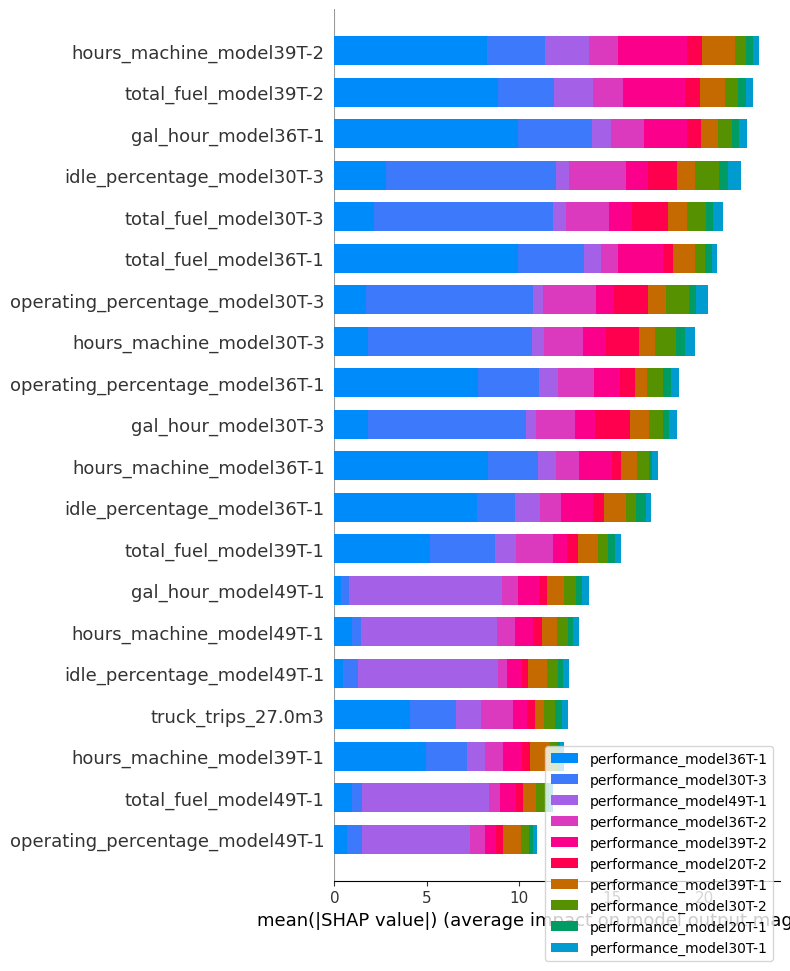

In [33]:
graf_tree_shap(best_model_rf, "rf", X_test, y_test)

### 5. PCA

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

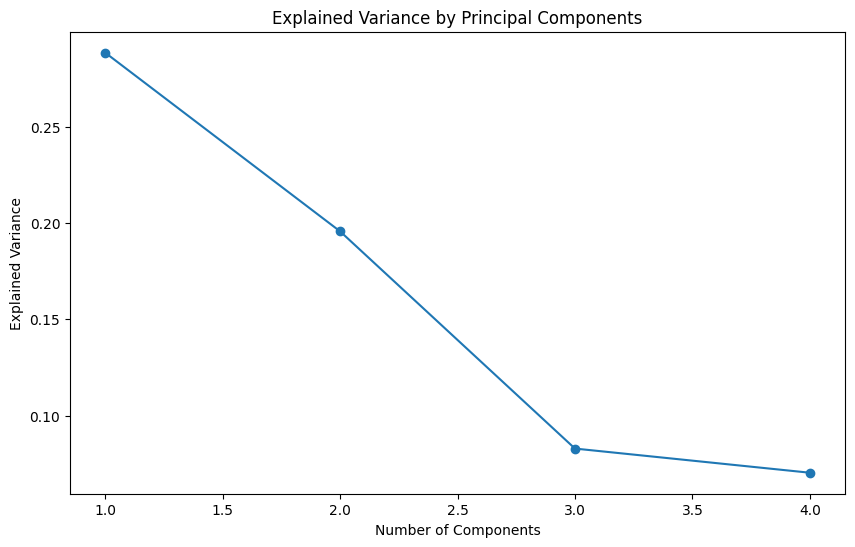

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y.values, test_size=.2, random_state =42)

reg = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)

models,predictions = reg.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

In [37]:
predictions.sort_values(by="R-Squared", ascending=False)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.48,0.62,47.63,0.19
BaggingRegressor,0.38,0.55,51.98,0.05
RandomForestRegressor,0.37,0.54,51.04,0.27
KNeighborsRegressor,0.21,0.42,57.83,0.03
ElasticNet,0.19,0.41,57.42,0.01
RidgeCV,0.09,0.33,56.69,0.02
DecisionTreeRegressor,0.03,0.29,59.36,0.01
Lasso,-0.03,0.25,57.97,0.02
LassoLars,-0.03,0.25,57.97,0.02


In [60]:
# pipeline_et = Pipeline([
#     ("scaler", StandardScaler()),
#     ("pca", PCA(n_components=4)),
#     ("et", ExtraTreesRegressor(random_state=42))
# ])

pipeline_et = Pipeline([
    ("log", LogTransformer()),
    ("pca", PCA(n_components=4)),
    ("et", ExtraTreesRegressor(random_state=42))
])


param_grid_et = {
    'et__n_estimators': [150,200,250,300],
    'et__max_depth': [None, 5, 7],
    'et__min_samples_split': [12, 5, 10],
    'et__min_samples_leaf': [1, 2, 4],
    'et__max_features': ['sqrt', 'log2']
}

grid_search_et = GridSearchCV(pipeline_et, param_grid_et, cv=KFold(10), scoring={'R2':'r2','RMSE':'neg_root_mean_squared_error'}, n_jobs=-1, refit="R2")
grid_search_et.fit(X_train, y_train)

print("Best hyperparameters ExtraTrees:", grid_search_et.best_params_)
best_model_et = grid_search_et.best_estimator_
y_pred_et = best_model_et.predict(X_test)
rmse_et = root_mean_squared_error(y_test, y_pred_et)
r2_et = r2_score(y_test, y_pred_et)
print(f'ExtraTrees RMSE: {rmse_et:.2f}')
print(f'ExtraTrees R2: {r2_et:.2f}')
print()

scores_et = cross_val_score(best_model_et, X, y, cv=KFold(10), scoring="neg_root_mean_squared_error")
print("Cross-val RMSE:", scores_et.round(2))
print(f'Mean RMSE score: {np.mean(scores_et):.2f}')

Best hyperparameters ExtraTrees: {'et__max_depth': 5, 'et__max_features': 'sqrt', 'et__min_samples_leaf': 1, 'et__min_samples_split': 5, 'et__n_estimators': 200}
ExtraTrees RMSE: 45.61
ExtraTrees R2: 0.56

Cross-val RMSE: [-36.35 -51.52 -30.71 -23.87 -29.09 -40.6  -48.43 -50.57 -65.12 -72.64]
Mean RMSE score: -44.89


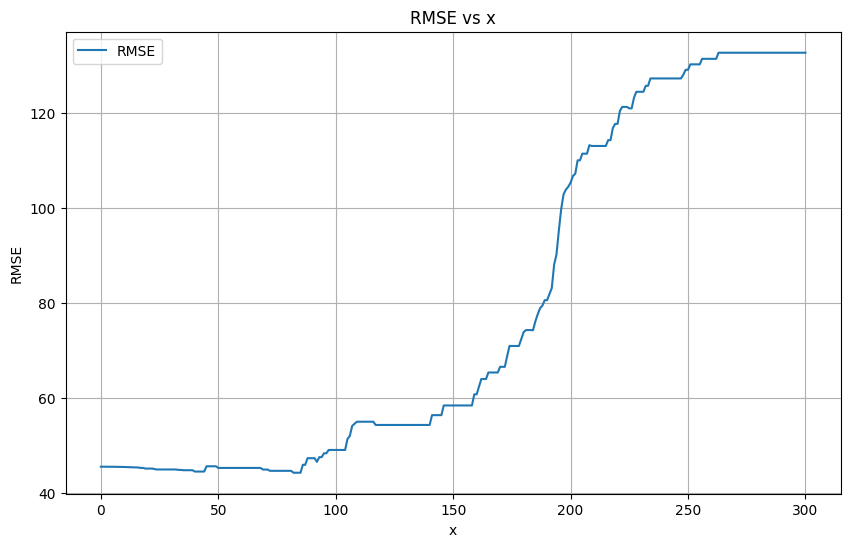

In [61]:
rmse_values1 = plot_rmse_vs_x(y_test, y_pred_et)

In [62]:
indices = np.where(rmse_values1 == np.min(rmse_values1))

if indices[0].size > 0:
    print(f'The value {np.min(rmse_values1)} is located at position {indices[0][0]}')
else:
    print(f'The value {np.min(rmse_values1)} is not found in the array')

The value 44.33611399193375 is located at position 82


In [63]:
y_model = y_pred_et.copy()
y_model[y_pred_et < indices[0][0]] = 0
rmse =root_mean_squared_error(y_test, y_model)
print(f'Mean Squared Error with the best model: {rmse:.2f}')

Mean Squared Error with the best model: 44.34


In [64]:
# Examine the component loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=X.columns)

# Sort variables by their contribution to the first principal component
sorted_loadings = loadings['PC1'].sort_values(ascending=False)
print("\nVariables sorted by their contribution to the first principal component:")
print()
sorted_loadings.head(10)


Variables sorted by their contribution to the first principal component:



,PC1
total_fuel_model39T-1,0.23
hours_machine_model39T-1,0.22
total_fuel_model39T-2,0.21
truck_trips_27.0m3,0.20
hours_machine_model39T-2,0.20
haul_truck_27.0m3,0.20
total_fuel_model20T-1,0.17
waste_prod,0.17
hours_machine_model20T-1,0.17
gal_hour_model39T-1,0.14


<Axes: >

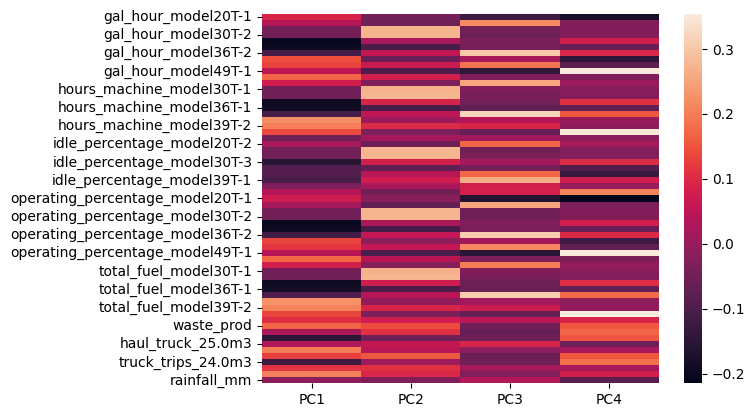

In [65]:
sns.heatmap(loadings)



### 5. Apply BayesSearchCV for hyperparameter optimization

In [66]:
# @title
def bayesian_optimization(model_pipeline, search_space, X, y):
    bayes_search = BayesSearchCV(
        estimator=model_pipeline,
        search_spaces=search_space,
        scoring="neg_root_mean_squared_error",
        n_iter=50,
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    bayes_search.fit(X, y)
    return bayes_search

In [68]:
# et_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('et', ExtraTreesRegressor(random_state=42))
# ])

pipeline_et = Pipeline([
    ("log", LogTransformer()),
    ('et', ExtraTreesRegressor(random_state=42))
])

et_space = {
    'et__n_estimators': Integer(20, 250),
    'et__max_depth': Integer(3, 30),
    'et__min_samples_split': Integer(2, 20),
    'et__min_samples_leaf': Integer(1, 10),
    'et__max_features': Categorical(['sqrt', 'log2', None])   #
}

X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42)


bayes_search_et = bayesian_optimization(et_pipeline, et_space, X_train, y_train)


print("best hiperparam ExtraTrees:", bayes_search_et.best_params_)

best_model_et = bayes_search_et.best_estimator_

best hiperparam ExtraTrees: OrderedDict({'et__max_depth': 21, 'et__max_features': 'log2', 'et__min_samples_leaf': 1, 'et__min_samples_split': 2, 'et__n_estimators': 200})


In [69]:
y_pred_et = best_model_et.predict(X_test)
rmse_et = root_mean_squared_error(y_test, y_pred_et)
r2_et = r2_score(y_test, y_pred_et)
print(f'ExtraTrees RMSE: {rmse_et:.2f}')
print(f'ExtraTrees R2: {r2_et:.2f}')
print()

scores_et = cross_val_score(best_model_et, X, y, cv=KFold(10), scoring="neg_root_mean_squared_error")
print("Cross-val RMSE:", scores_et.round(2))
print(f'Mean RMSE score: {np.mean(scores_et):.2f}')

ExtraTrees RMSE: 42.94
ExtraTrees R2: 0.60

Cross-val RMSE: [-31.95 -42.06 -33.05 -24.64 -34.62 -38.46 -45.87 -45.37 -60.1  -70.73]
Mean RMSE score: -42.68


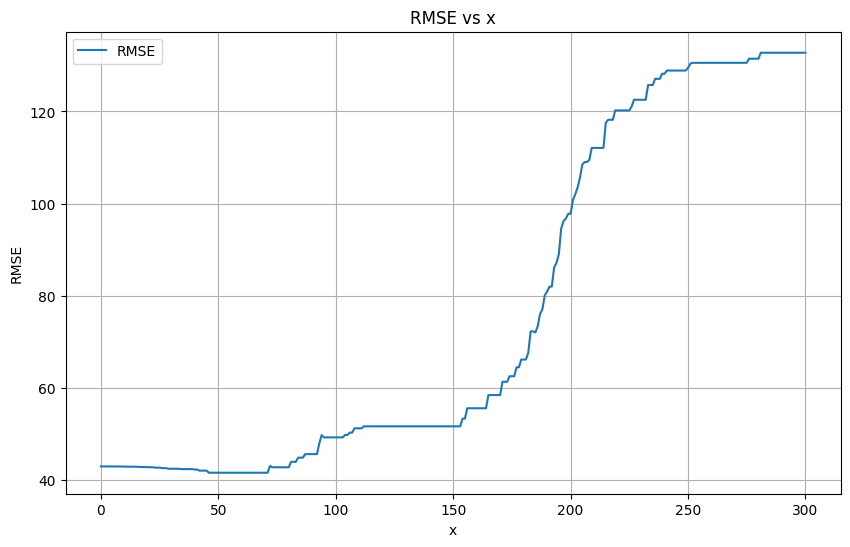

In [70]:
rmse_valueset = plot_rmse_vs_x(y_test, y_pred_et)

In [71]:
indices = np.where(rmse_valueset == np.min(rmse_valueset))

if indices[0].size > 0:
    print(f'The value {np.min(rmse_valueset)} is located at position {indices[0][0]}')
else:
    print(f'The value {np.min(rmse_valueset)} is not found in the array')

The value 41.56336932187835 is located at position 46


In [73]:
y_model= y_pred_et.copy()
y_model[y_pred_et < indices[0][0]] = 0
rmse = root_mean_squared_error(y_test, y_model)
print(f'Mean Squared Error with the best model: {rmse:.2f}')

Mean Squared Error with the best model: 41.56


### 6. Model Evaluation

### 6.1 charging all year information data

In [74]:
dfyear = pd.read_csv("/content/df_year_performance.csv",index_col=0)

In [75]:
column_order = X.columns

dfyear = dfyear[column_order]

In [76]:
# @title
y_new_pred = best_model_et.predict(dfyear)
y_new_pred2  = y_new_pred.copy()
y_new_pred2[y_new_pred < 46] = 0
result = pd.DataFrame(data=y_new_pred2, columns=y.columns, index=dfyear.index)

### 6.2 performance of the shovels

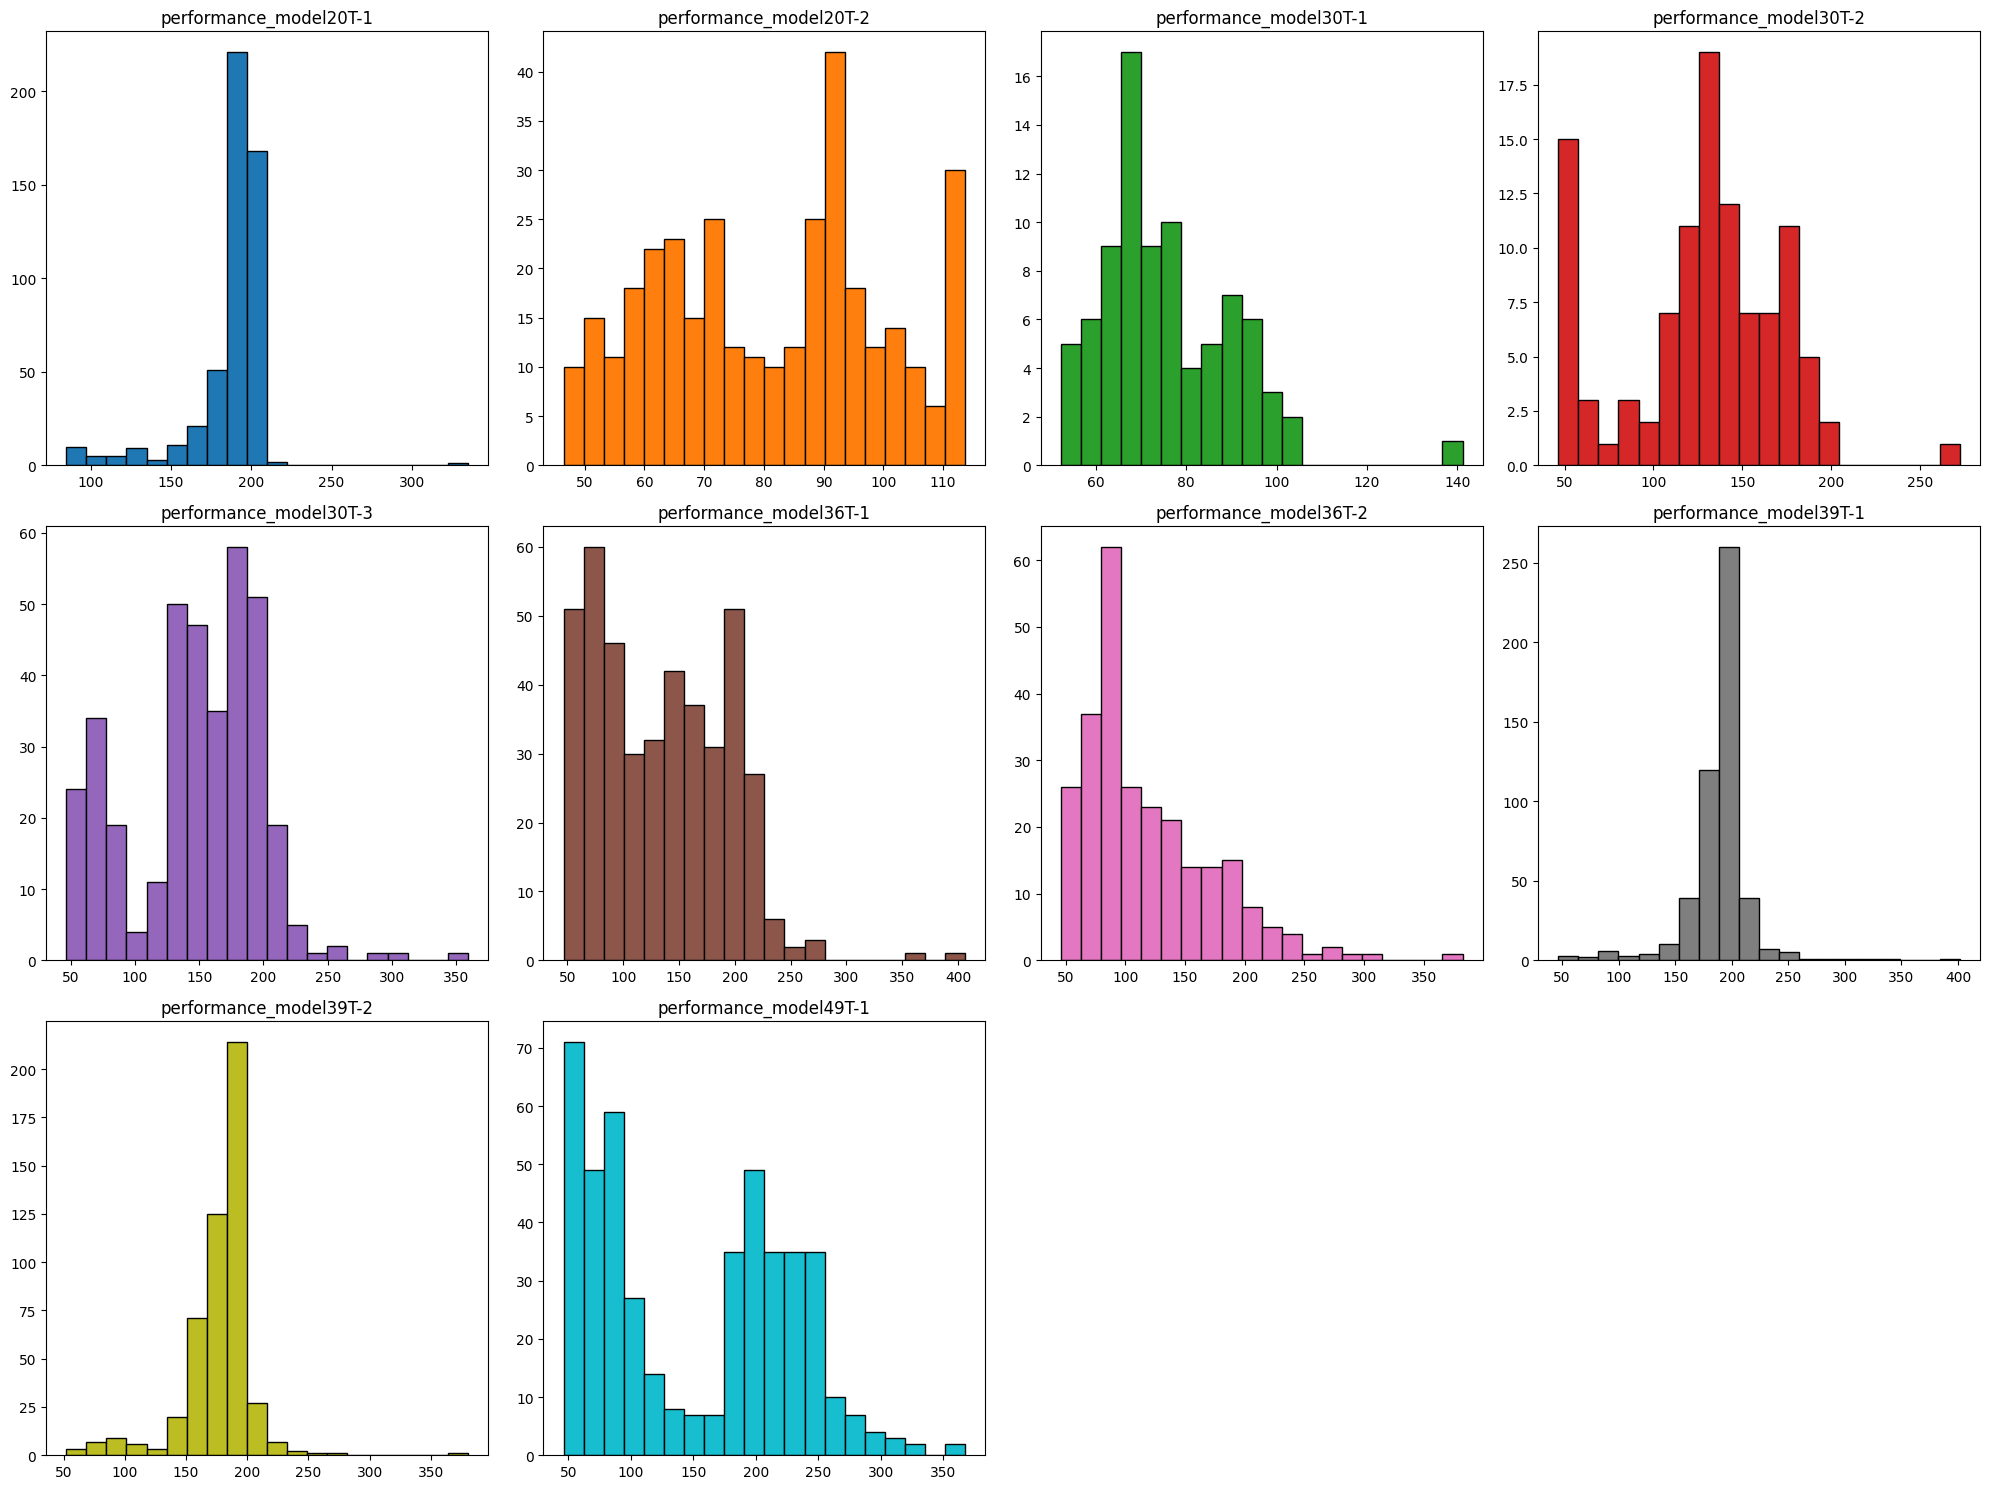

In [77]:
# @title
colors = plt.get_cmap('tab10', result.shape[1]).colors

num_columns = result.shape[1]

columns_per_row = 4

rows = (num_columns + columns_per_row - 1) // columns_per_row

fig, axes = plt.subplots(rows, columns_per_row, figsize=(20, 5 * rows))

axes = axes.flatten()

for i, column in enumerate(result.columns):
    filtered_data = result[column][result[column] != 0]
    axes[i].hist(filtered_data.dropna(), bins=20, edgecolor='black', color=colors[i % len(colors)])
    axes[i].set_title(column)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()

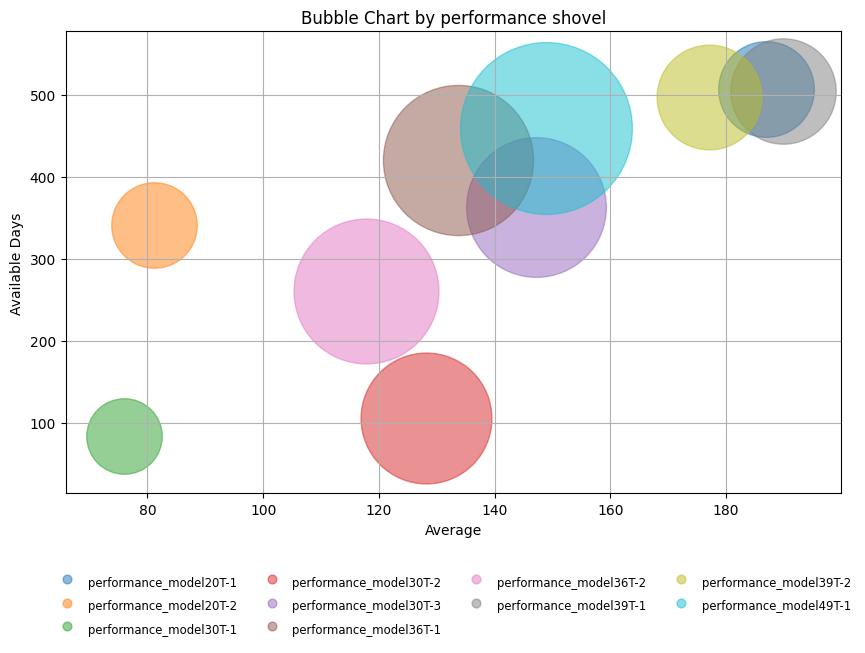

In [78]:
df_filtered = result.replace(0, np.nan)

averages = df_filtered.mean()
std_devs = df_filtered.std()
activity = df_filtered.count()

fig, ax = plt.subplots(figsize=(10, 6))

for i, column in enumerate(result.columns):
    ax.scatter(averages.iloc[i], activity.iloc[i],
               s=std_devs.iloc[i]*200,
               alpha=0.5,
               label=column)

ax.set_xlabel('Average')
ax.set_ylabel('Available Days')

ax.set_xlim(averages.min() - 10, averages.max() + 10)
ax.set_ylim(activity.min() - 70, activity.max() + 70)

legend = ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center',
                   fontsize='small', title_fontsize='small', scatterpoints=1,
                   handleheight=2, handlelength=2, ncol=4, frameon=False)

for handle in legend.legend_handles:
    handle._sizes = [40]

plt.title('Bubble Chart by performance shovel')
plt.grid(True)
plt.show()

